# Evaluación del caso “Kicked Kepler con impulsos periódicos”

Analizamos un sistema Kepleriano perturbado: una estrella central y una partícula ligera que recibe impulsos periódicos en velocidad. El objetivo es encontrar masas dentro de rangos estrechos que mitiguen la respuesta caótica y favorezcan órbitas cuasi periódicas pese a las perturbaciones.

> **Interpretación**
> - La métrica de Lyapunov indica qué tan sensible es la órbita ante el “kick” periódico; valores más bajos implican trayectorias controladas.
> - La penalización de periodicidad ayuda a que el estado tras cada ciclo completo de impulsos permanezca próximo al inicial.


## Preparación del entorno

Localizamos la carpeta raíz `two_body`, la añadimos a `sys.path` y definimos `PARENT` para acceder a utilidades compartidas. Así evitamos problemas de importación sin importar dónde se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias clave del pipeline

Importamos la configuración (`Config`), el controlador híbrido, los visualizadores 2D/3D, el adaptador REBOUND base y utilidades como `numpy` y `Path` para manejar resultados y artefactos.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path  # si quieres guardar animaciones/figuras


## Instrumentación de rendimiento

Activamos `PERF_TIMINGS_ENABLED` y cargamos las herramientas de la suite de tiempos (`time_block`, `latest_timing_csv`, etc.). Esto permitirá inspeccionar los costos de cada fase del experimento Kicked Kepler.


In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Formato de logging amigable en notebook

Creamos un `NotebookHandler` que acumula los mensajes del optimizador y los imprime progresivamente. Mantiene el contexto de ejecución visible sin saturar la salida con trazas crudas.


In [4]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="INFO")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.INFO)


## Configuración del escenario “Kicked Kepler”

Definimos el diccionario `case` con:
- Integración rápida (`t_end_short = 300`) y una integración larga exigente (`t_end_long = 8000`) para validar periodicidad.
- Estado inicial Kepleriano casi circular (`r0`, `v0`) más un “kick” ligero en `vy`.
- Rangos de masa muy estrechos para la estrella y el test particle, lo que obliga al optimizador a trabajar con ajustes finos.
- Parámetros evolutivos moderados (`pop_size = 80`, `max_epochs = 15`) y `periodicity_weight = 0.08` para penalizar la deriva tras múltiples impulsos.
- Tres parámetros nuevos (`kick_period`, `kick_delta_v`, `kick_target`) que describen la perturbación periódica.


In [ ]:
# Kicked Kepler
case = {
    "t_end_short": 300.0,
    "t_end_long": 8000.0,
    "dt": 0.05,
    "integrator": "whfast",   # o "ias15" para pasos adaptativos
    "r0": ((-1.0, 0.0, 0.0), (1e-3, 0.0, 0.0)),
    "v0": ((0.0, -0.8, 0.0), (0.0, 25.0, 0.0)),
    "mass_bounds": (
        (0.99, 1.01),      # masa central
        (9.5e-5, 1.1e-4),  # partícula test
    ),
    "G": 1.0,
    "pop_size": 80,
    "n_gen_step": 1,
    "mutation": 0.08,
    "max_epochs": 15,
    "top_k_long": 10,
    "headless": False,
    "periodicity_weight": 0.08,
    "kick_period": 2*np.pi,        #
    "kick_delta_v": (0.0, 0.03, 0.0),
    "kick_target": 1,
}


In [6]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

_kick_keys = (
    "kick_period",
    "kick_delta_v",
    "kick_target",
)
config_kwargs = {k: v for k, v in case.items() if k not in _kick_keys}

cfg = Config(**config_kwargs)
logger = setup_logger()

## Adaptador REBOUND con impulsos periódicos

Subclasamos `ReboundSim` para construir `KickedKeplerSim`, que aplica un incremento de velocidad `Δv` al cuerpo objetivo cada `kick_period`. Registramos la función en `post_timestep_modifications` y monkeypatcheamos el módulo `rebound_adapter` para que el resto del pipeline use este integrador “pateado”.


In [7]:
from two_body.simulation.rebound_adapter import ReboundSim as _BaseReboundSim
kick_period = case["kick_period"]
kick_delta_v = case["kick_delta_v"]
kick_target = case["kick_target"]

class KickedKeplerSim(_BaseReboundSim):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._kick_period = kick_period
        self._kick_delta_v = kick_delta_v
        self._kick_target = kick_target

    def setup_simulation(self, *args, **kwargs):
        sim = super().setup_simulation(*args, **kwargs)
        next_kick = {"t": sim.t + self._kick_period}
        dv = self._kick_delta_v

        def apply_kick(_ptr=None):
            while sim.t >= next_kick["t"] - 1e-12:
                p = sim.particles[self._kick_target]
                p.vx += dv[0]
                p.vy += dv[1]
                p.vz += dv[2]
                next_kick["t"] += self._kick_period

        sim.post_timestep_modifications = apply_kick
        return sim

# Monkeypatch para que todo el pipeline use el adaptador pateado
from two_body.simulation import rebound_adapter
rebound_adapter.ReboundSim = KickedKeplerSim

In [8]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.99, 1.01), (9.5e-05, 0.00011)) 15 10000


## Ejecución del controlador híbrido

Instanciamos `Config`, el `logger` y el `ContinuousOptimizationController`. Envolvemos `controller.run()` dentro de `time_block("notebook_run")` para medir la ejecución completa (GA + refinamiento continuo) bajo el régimen de impulsos periódicos.


In [9]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-10-29 00:08:23,033] INFO - Starting optimization | pop=80 | dims=2 | time_budget=1800.0s | eval_budget=10000


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[2025-10-29 00:08:30,959] INFO - Epoch 0 | new global best (short) lambda=0.002206 | fitness=-618.268673 | penalty=7728.330839 | masses=(1.009713, 9.9e-05)
[2025-10-29 00:08:56,358] INFO - Epoch 0 complete | lambda_short=0.002206 | fitness_short=-618.268673 | lambda_best=0.002206 | fitness_best=-618.268673 | evals short/long=80/10 | total evals=90 | radius=0.1000
[2025-10-29 00:09:05,065] INFO - Epoch 1 | new global best (short) lambda=0.001779 | fitness=-618.268179 | penalty=7728.330005 | masses=(1.009785, 9.9e-05)
[2025-10-29 00:09:29,913] INFO - Epoch 1 complete | lambda_short=0.001779 | fitness_short=-618.268179 | lambda_best=0.001779 | fitness_best=-618.268179 | evals short/long=80/10 | total evals=180 | radius=0.1000
[2025-10-29 00:10:01,650] INFO - Epoch 2 complete | lambda_short=0.002204 | fitness_short=-618.275932 | lambda_best=0.001779 | fitness_best=-618.268179 | evals short/long=80/10 | total evals=270 | radius=0.1000
[2025-10-29 00:10:36,036] INFO - Epoch 3 complete | lamb

## Métricas de referencia y solución óptima

Calculamos el fitness del punto central de los rangos de masa (`center`) y lo comparamos con `results["best"]`. Obtenemos `baseline_details` para revisar cómo afectan los kicks al exponente de Lyapunov y conservamos `metrics` para graficar la evolución de λ y del fitness.


In [10]:
metrics = controller.metrics
results

{'status': 'completed',
 'best': {'masses': [1.01, 0.00011],
  'lambda': 0.0018216158084116186,
  'fitness': -618.2680127057457,
  'm1': 1.01,
  'm2': 0.00011},
 'evals': 1350,
 'epochs': 15}

In [11]:
from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)

baseline_fits, baseline_details = evaluator.evaluate_batch(
    [center],
    horizon="long",
    return_details=True,
)
baseline_fit = baseline_fits[0]
baseline_lambda = baseline_details[0].get("lambda")
if baseline_lambda is None or not np.isfinite(baseline_lambda):
    baseline_lambda = -baseline_fit

best_payload = results.get("best", {})
best_fit = best_payload.get("fitness")
best_lambda = best_payload.get("lambda")
if best_lambda is None and best_fit is not None:
    best_lambda = -best_fit

print(
    f"lambda inicial = {baseline_lambda:.6f}, "
    f"lambda optimo = {best_lambda if best_lambda is not None else 'N/A'}"
)

lambda inicial = 0.000007, lambda optimo = 0.0018216158084116186


## Visualización y seguimiento de convergencia

Mostramos:
- `plot_lambda_evolution` y `plot_fitness_evolution` para estudiar cómo responde el GA ante los impulsos repetidos.
- Las trayectorias integradas con las masas óptimas (`xyz_tracks`) tanto en vista rápida 2D (`quick_view`) como en la animación 3D final, verificando si la órbita se mantiene acotada tras sucesivos kicks.


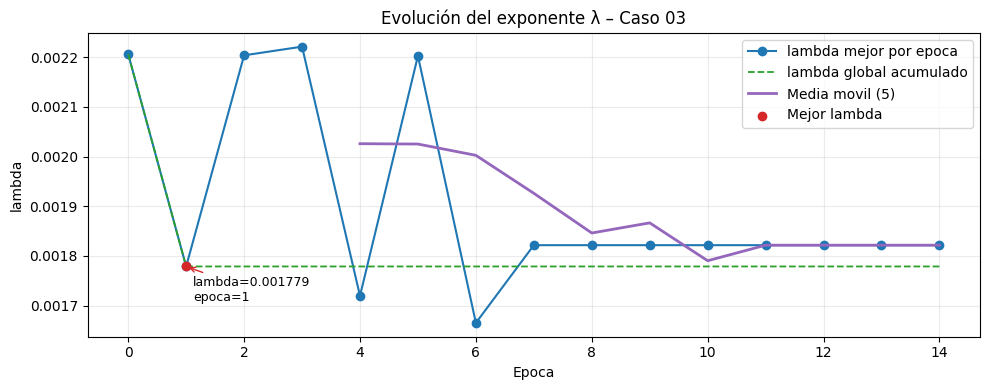

In [12]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 03",
    moving_average_window=5,   # opcional
)

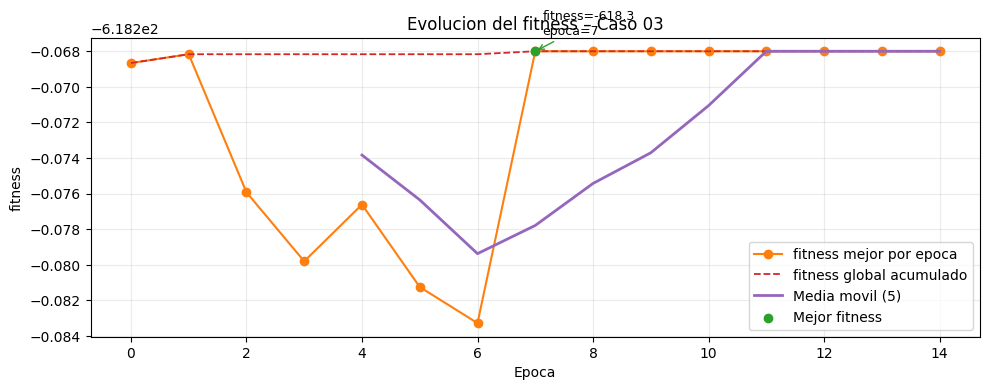

In [13]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 03",
    moving_average_window=5,
)


In [14]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]

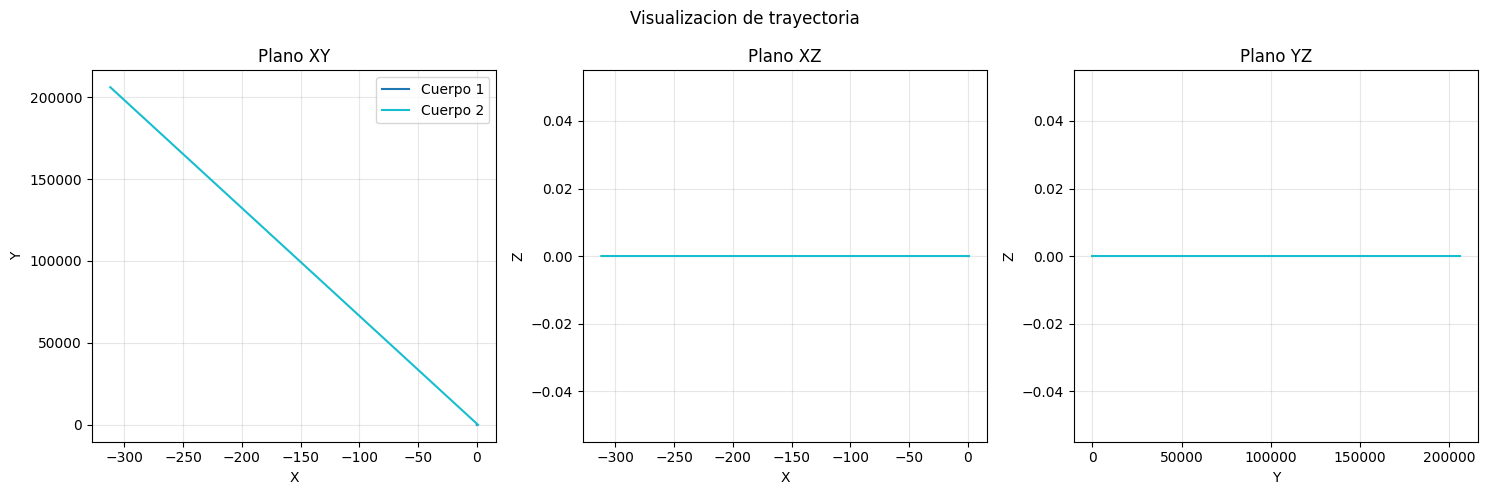

In [15]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks) 

In [16]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 1024  # MB

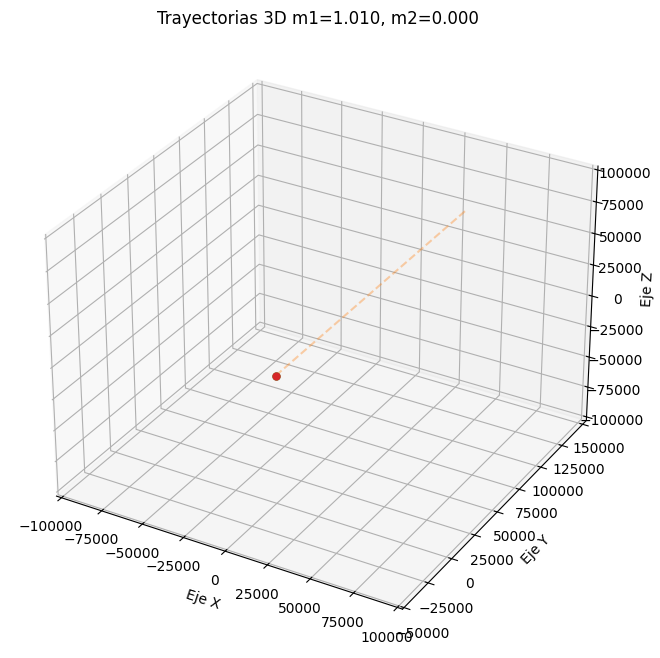

In [17]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Configuramos un `FFMpegWriter`, creamos `artifacts/caso03` (ajusta la ruta si lo prefieres) y guardamos los MP4 de la trayectoria y de la comparación de masas. Puedes modificar `fps`, `bitrate` o el preset de ffmpeg si necesitas acelerar el render.


In [20]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(
    fps=20,
    bitrate=1800,
    extra_args=["-vcodec", "libx264", "-preset", "ultrafast", "-crf", "28"]
)

output_path = Path("artifacts/caso01")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

In [ ]:
anim_mass = viz_3d.plot_mass_comparison(
    original_masses=center,
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(best_masses))],
    title="Comparativa de masas (Caso 01)",
)
#HTML(anim_mass.to_jshtml())  

In [ ]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos de ejecución

Leemos el CSV generado por la instrumentación, mostramos una vista preliminar y agregamos estadísticas por sección para detectar qué partes del flujo (simulación con kicks, evaluación larga, etc.) dominan el costo computacional en este caso.


In [ ]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_6576442c-2815-4e04-94bb-9833e5d3eaa9_20251028_060149.csv'

,run_id,epoch,batch_id,individual_id,section,start_ns,end_ns,duration_us,extra
0,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194440700,42514194489200,48,"{'step': 0, 'dt': 0.05, 't_target': 0.05}"
1,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194542400,42514194553800,11,"{'step': 1, 'dt': 0.05, 't_target': 0.1}"
2,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194578800,42514194587300,8,"{'step': 2, 'dt': 0.05, 't_target': 0.15000000..."
3,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194604900,42514194611200,6,"{'step': 3, 'dt': 0.05, 't_target': 0.2}"
4,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194627100,42514194633800,6,"{'step': 4, 'dt': 0.05, 't_target': 0.25}"
5,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194647600,42514194653500,5,"{'step': 5, 'dt': 0.05, 't_target': 0.30000000..."
6,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194665600,42514194671400,5,"{'step': 6, 'dt': 0.05, 't_target': 0.35000000..."
7,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194683200,42514194689500,6,"{'step': 7, 'dt': 0.05, 't_target': 0.4}"
8,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194700800,42514194706100,5,"{'step': 8, 'dt': 0.05, 't_target': 0.45}"
9,6576442c-2815-4e04-94bb-9833e5d3eaa9,0,0,0,simulation_step,42514194717000,42514194722800,5,"{'step': 9, 'dt': 0.05, 't_target': 0.5}"


,count,mean,sum
section,,,
notebook_run,1,2.909833e+08,290983335
batch_eval,31,9.335158e+06,289389902
fitness_eval,1348,2.146547e+05,289354498
lyapunov_compute,708,4.081245e+05,288952175
simulation_step,15495994,5.257146e+00,81464707
ga_main,15,3.681453e+04,552218
crossover,709,4.398237e+02,311835
mutation,709,1.815261e+02,128702
selection_tournament,709,1.708843e+02,121157


Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id 6576442c-2815-4e04-94bb-9833e5d3eaa9 --top-n 5
Graficas guardadas en C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies\two_body\reports




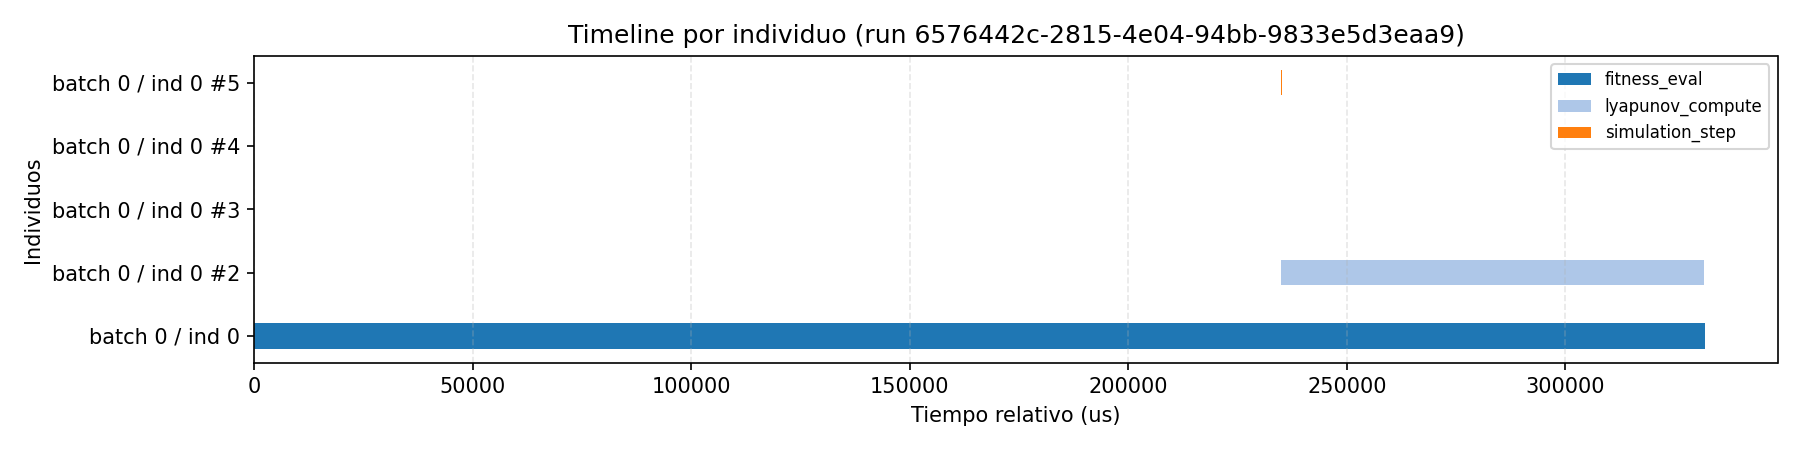

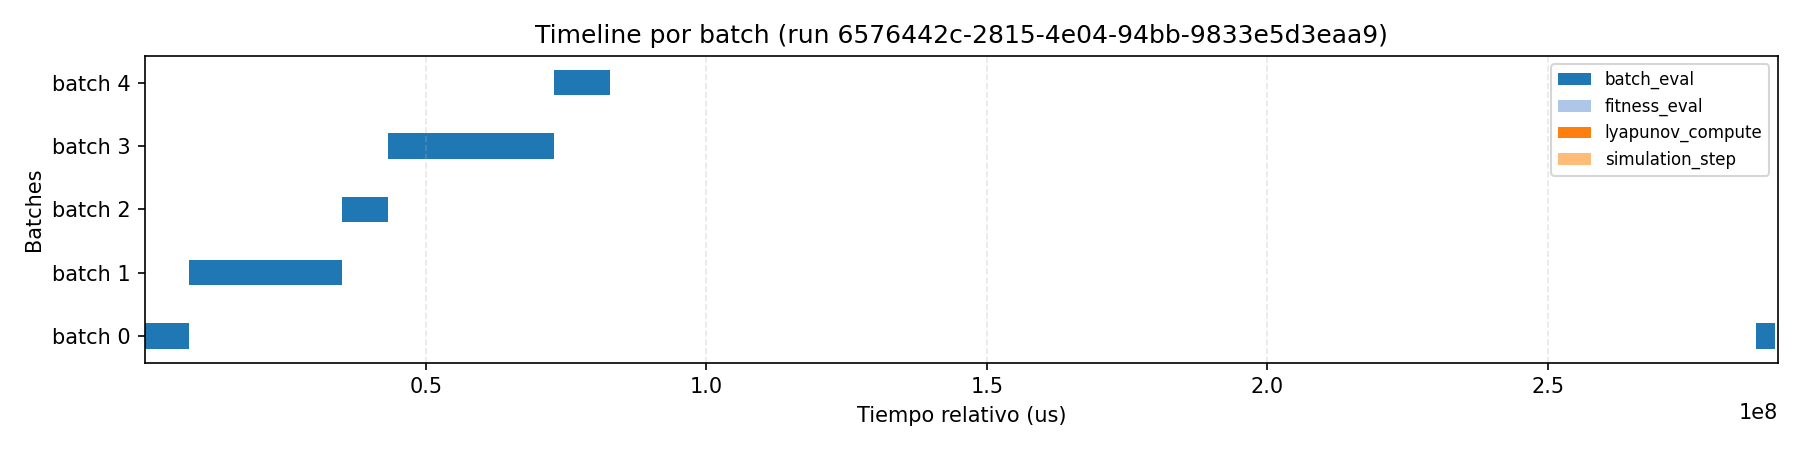

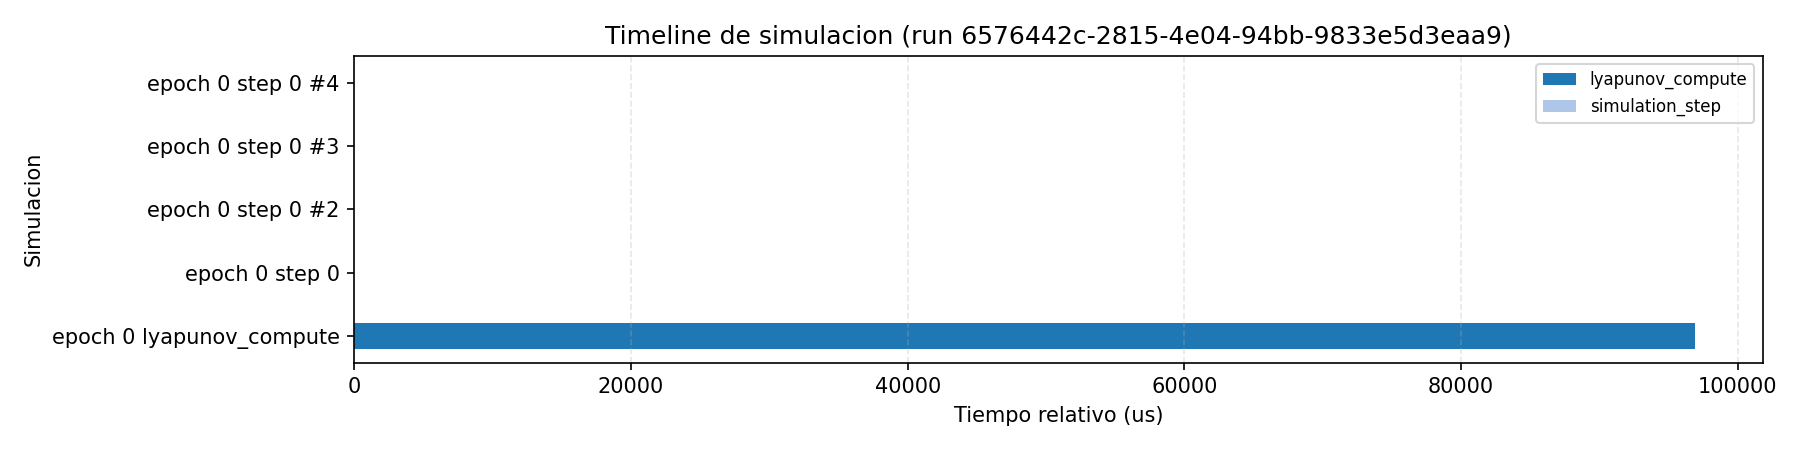

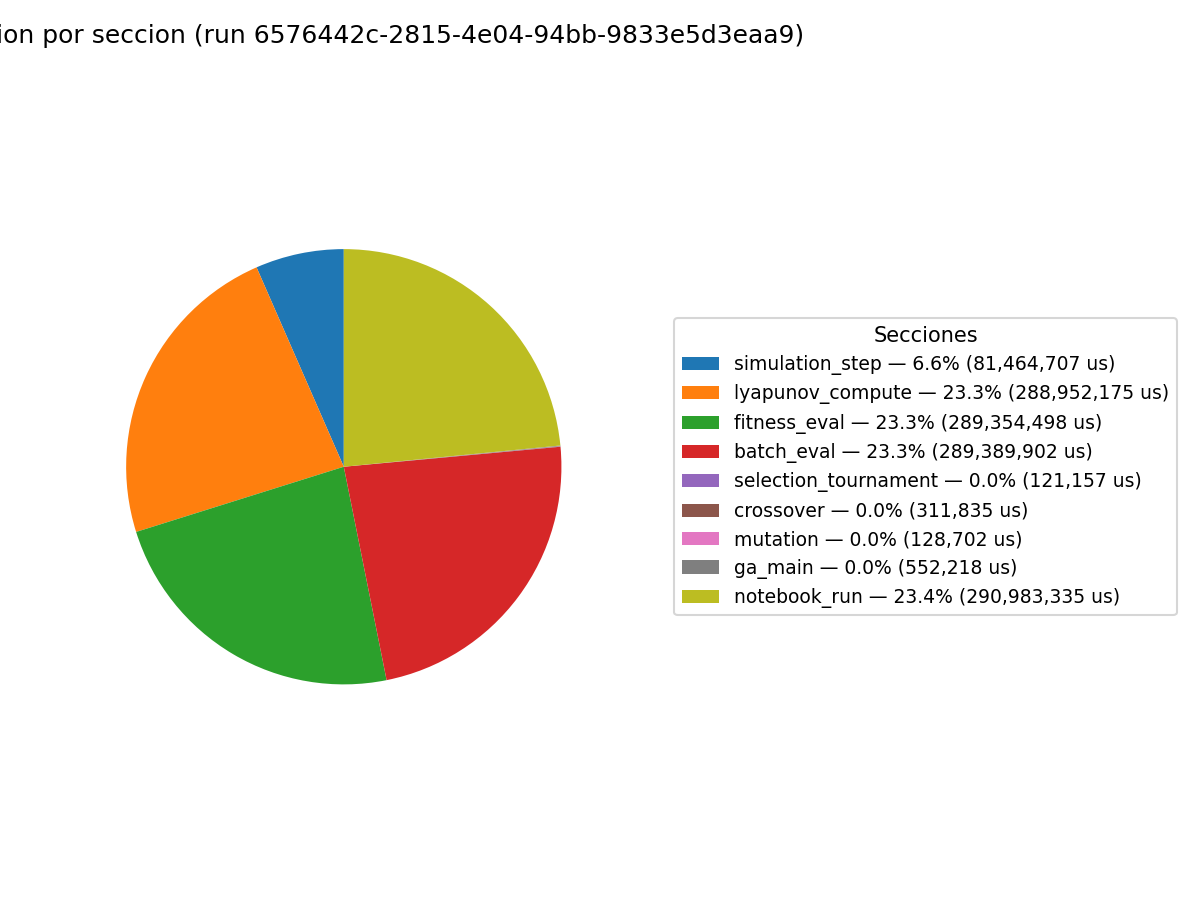

In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)